# Generación de Música con Transformers 🎶

In [1]:
%load_ext autoreload
%autoreload 2

import os
import glob
import numpy as np
import time
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, losses, callbacks

import music21

from transformer_utils import (
    parse_midi_files,
    load_parsed_files,
    get_midi_note,
    SinePositionEncoding,
)

In [2]:
# Set device to GPU if available
device_name = tf.test.gpu_device_name()
if device_name != "/device:GPU:0":
    print(
        "GPU device not found. Training might be slow. "
        "You can try running this notebook on Google Colab "
        "to access free GPU resources."
    )
else:
    print("Found GPU at: {}".format(device_name))

Found GPU at: /device:GPU:0


2025-12-04 12:52:33.028323: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-12-04 12:52:33.028348: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2025-12-04 12:52:33.028356: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.66 GB
I0000 00:00:1764874353.028369   41713 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1764874353.028388   41713 pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## 0. Parameters <a name="parameters"></a>

In [3]:
PARSED_DATA_PATH = "./parsed_data/"
DATASET_REPETITIONS = 1

SEQ_LEN = 50
EMBEDDING_DIM = 256
KEY_DIM = 256
N_HEADS = 5
DROPOUT_RATE = 0.3
FEED_FORWARD_DIM = 256
LOAD_MODEL = True

# optimization
EPOCHS = 2000
BATCH_SIZE = 256

GENERATE_LEN = 50

## 1. Prepare the Data

In [4]:
import os
import requests

midi_dir = './data/bach-cello/'
os.makedirs(midi_dir, exist_ok=True)

urls = [
    'http://www.jsbach.net/midi/cs1-1pre.mid',
    'http://www.jsbach.net/midi/cs1-2all.mid',
    'http://www.jsbach.net/midi/cs1-3cou.mid',
    'http://www.jsbach.net/midi/cs1-4sar.mid',
    'http://www.jsbach.net/midi/cs1-5men.mid',
    'http://www.jsbach.net/midi/cs1-6gig.mid',
    'http://www.jsbach.net/midi/cs2-1pre.mid',
    'http://www.jsbach.net/midi/cs2-2all.mid',
    'http://www.jsbach.net/midi/cs2-3cou.mid',
    'http://www.jsbach.net/midi/cs2-4sar.mid',
    'http://www.jsbach.net/midi/cs2-5men.mid',
    'http://www.jsbach.net/midi/cs2-6gig.mid',
    'http://www.jsbach.net/midi/cs3-1pre.mid',
    'http://www.jsbach.net/midi/cs3-2all.mid',
    'http://www.jsbach.net/midi/cs3-3cou.mid',
    'http://www.jsbach.net/midi/cs3-4sar.mid',
    'http://www.jsbach.net/midi/cs3-5bou.mid',
    'http://www.jsbach.net/midi/cs3-6gig.mid',
    'http://www.jsbach.net/midi/cs4-1pre.mid',
    'http://www.jsbach.net/midi/cs4-2all.mid',
    'http://www.jsbach.net/midi/cs4-3cou.mid',
    'http://www.jsbach.net/midi/cs4-4sar.mid',
    'http://www.jsbach.net/midi/cs4-5bou.mid',
    'http://www.jsbach.net/midi/cs4-6gig.mid',
    'http://www.jsbach.net/midi/cs5-1pre.mid',
    'http://www.jsbach.net/midi/cs5-2all.mid',
    'http://www.jsbach.net/midi/cs5-3cou.mid',
    'http://www.jsbach.net/midi/cs5-4sar.mid',
    'http://www.jsbach.net/midi/cs5-5gav.mid',
    'http://www.jsbach.net/midi/cs5-6gig.mid',
    'http://www.jsbach.net/midi/cs6-1pre.mid',
    'http://www.jsbach.net/midi/cs6-2all.mid',
    'http://www.jsbach.net/midi/cs6-3cou.mid',
    'http://www.jsbach.net/midi/cs6-4sar.mid',
    'http://www.jsbach.net/midi/cs6-5gav.mid',
    'http://www.jsbach.net/midi/cs6-6gig.mid',
]

print('Downloading...')
for url in urls:
    filename = os.path.join(midi_dir, url.split('/')[-1])
    if not os.path.exists(filename):
        r = requests.get(url)
        with open(filename, 'wb') as f:
            f.write(r.content)
        print(f'Downloaded {filename}')
    else:
        print(f'Skipped {filename} (already exists)')
print('🚀 Done!')

Downloading...
Skipped ./data/bach-cello/cs1-1pre.mid (already exists)
Skipped ./data/bach-cello/cs1-2all.mid (already exists)
Skipped ./data/bach-cello/cs1-3cou.mid (already exists)
Skipped ./data/bach-cello/cs1-4sar.mid (already exists)
Skipped ./data/bach-cello/cs1-5men.mid (already exists)
Skipped ./data/bach-cello/cs1-6gig.mid (already exists)
Skipped ./data/bach-cello/cs2-1pre.mid (already exists)
Skipped ./data/bach-cello/cs2-2all.mid (already exists)
Skipped ./data/bach-cello/cs2-3cou.mid (already exists)
Skipped ./data/bach-cello/cs2-4sar.mid (already exists)
Skipped ./data/bach-cello/cs2-5men.mid (already exists)
Skipped ./data/bach-cello/cs2-6gig.mid (already exists)
Skipped ./data/bach-cello/cs3-1pre.mid (already exists)
Skipped ./data/bach-cello/cs3-2all.mid (already exists)
Skipped ./data/bach-cello/cs3-3cou.mid (already exists)
Skipped ./data/bach-cello/cs3-4sar.mid (already exists)
Skipped ./data/bach-cello/cs3-5bou.mid (already exists)
Skipped ./data/bach-cello/cs3-6gi

In [5]:
# Load the data
file_list = glob.glob("./data/bach-cello/*.mid")
print(f"Found {len(file_list)} midi files")

Found 36 midi files


In [6]:
parser = music21.converter

In [7]:
example_score = (
    music21.converter.parse(file_list[1]).splitAtQuarterLength(12)[0].chordify()
)

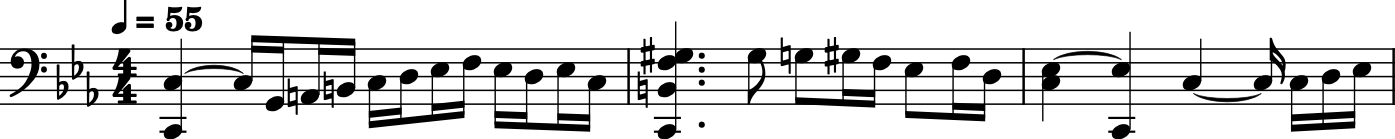

In [8]:
example_score.show()

In [9]:
example_score.show("text")

{0.0} <music21.metadata.Metadata object at 0x14a2a3a10>
{0.0} <music21.stream.Measure 1 offset=0.0>
    {0.0} <music21.instrument.Violoncello 'Solo Cello: Solo Cello'>
    {0.0} <music21.instrument.Violoncello 'Violoncello'>
    {0.0} <music21.clef.BassClef>
    {0.0} <music21.tempo.MetronomeMark adagio Quarter=55>
    {0.0} <music21.key.Key of E- major>
    {0.0} <music21.meter.TimeSignature 4/4>
    {0.0} <music21.chord.Chord C2 C3>
    {1.0} <music21.chord.Chord C3>
    {1.25} <music21.chord.Chord G2>
    {1.5} <music21.chord.Chord A2>
    {1.75} <music21.chord.Chord B2>
    {2.0} <music21.chord.Chord C3>
    {2.25} <music21.chord.Chord D3>
    {2.5} <music21.chord.Chord E-3>
    {2.75} <music21.chord.Chord F3>
    {3.0} <music21.chord.Chord E-3>
    {3.25} <music21.chord.Chord D3>
    {3.5} <music21.chord.Chord E-3>
    {3.75} <music21.chord.Chord C3>
{4.0} <music21.stream.Measure 2 offset=4.0>
    {0.0} <music21.chord.Chord C2 B2 F3 G#3>
    {1.5} <music21.chord.Chord G#3>
    {2.

In [10]:
if not os.path.exists(PARSED_DATA_PATH + "notes") and not os.path.exists(PARSED_DATA_PATH + "durations"):
    notes, durations = parse_midi_files(
        file_list, parser, SEQ_LEN + 1, PARSED_DATA_PATH
    )
else:
    notes, durations = load_parsed_files(PARSED_DATA_PATH)

In [11]:
example_notes = notes[658]
example_durations = durations[658]
print("\nNotes string\n", example_notes, "...")
print("\nDuration string\n", example_durations, "...")


Notes string
 G3 B3 C4 G3 E3 D3 C3 E3 A3 C4 F#3 A3 C4 E4 D4 C3 B2 G3 A2 G2 D2 A2 G3 F#3 G3 G2 B2 D3 G3 B3 D4 F#4 G4 D4 B3 G3 G2 A3 A3 F#3 G3 A3 D3 E3 F#3 G3 A3 F#3 D3 C3 B2 ...

Duration string
 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.75 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.75 0.25 1.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 ...


## 2. Tokenize the data <a name="tokenize"></a>

In [12]:
def create_dataset(elements):
    ds = (
        tf.data.Dataset.from_tensor_slices(elements)
        .batch(BATCH_SIZE, drop_remainder=True)
        .shuffle(1000)
    )
    vectorize_layer = layers.TextVectorization(
        standardize=None, output_mode="int"
    )
    vectorize_layer.adapt(ds)
    vocab = vectorize_layer.get_vocabulary()
    return ds, vectorize_layer, vocab


notes_seq_ds, notes_vectorize_layer, notes_vocab = create_dataset(notes)
durations_seq_ds, durations_vectorize_layer, durations_vocab = create_dataset(
    durations
)
seq_ds = tf.data.Dataset.zip((notes_seq_ds, durations_seq_ds))

I0000 00:00:1764874353.990379   41713 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1764874353.990403   41713 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-12-04 12:52:34.630930: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-12-04 12:52:35.221465: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [13]:
# Display the same example notes and durations converted to ints
example_tokenised_notes = notes_vectorize_layer(example_notes)
example_tokenised_durations = durations_vectorize_layer(example_durations)
print("{:10} {:10}".format("note token", "duration token"))
for i, (note_int, duration_int) in enumerate(
    zip(
        example_tokenised_notes.numpy()[:11],
        example_tokenised_durations.numpy()[:11],
    )
):
    print(f"{note_int:10}{duration_int:10}")

note token duration token
         2         2
         9         2
         6         2
         2         2
         8         2
         4         2
        13         2
         8         2
         3         2
         6         2
        12         2


In [14]:
notes_vocab_size = len(notes_vocab)
durations_vocab_size = len(durations_vocab)

# Display some token:note mappings
print(f"\nNOTES_VOCAB: length = {len(notes_vocab)}")
for i, note in enumerate(notes_vocab[:10]):
    print(f"{i}: {note}")

print(f"\nDURATIONS_VOCAB: length = {len(durations_vocab)}")
# Display some token:duration mappings
for i, note in enumerate(durations_vocab[:10]):
    print(f"{i}: {note}")


NOTES_VOCAB: length = 59
0: 
1: [UNK]
2: G3
3: A3
4: D3
5: F3
6: C4
7: D4
8: E3
9: B3

DURATIONS_VOCAB: length = 24
0: 
1: [UNK]
2: 0.25
3: 0.5
4: 1.0
5: 1/3
6: 0.75
7: 1/12
8: 1.5
9: 0.0


## 3. Create the Training Set <a name="create"></a>

In [15]:
# Create the training set of sequences and the same sequences shifted by one note
def prepare_inputs(notes, durations):
    notes = tf.expand_dims(notes, -1)
    durations = tf.expand_dims(durations, -1)
    tokenized_notes = notes_vectorize_layer(notes)
    tokenized_durations = durations_vectorize_layer(durations)
    x = (tokenized_notes[:, :-1], tokenized_durations[:, :-1])
    y = (tokenized_notes[:, 1:], tokenized_durations[:, 1:])
    return x, y


ds = seq_ds.map(prepare_inputs).repeat(DATASET_REPETITIONS)

In [16]:
example_input_output = ds.take(1).get_single_element()
print(example_input_output)

((<tf.Tensor: shape=(256, 50), dtype=int64, numpy=
array([[ 7,  5, 19, ...,  5, 12, 12],
       [ 5, 19, 23, ..., 12, 12,  8],
       [19, 23,  6, ..., 12,  8, 10],
       ...,
       [ 5,  8,  4, ..., 18,  2,  5],
       [ 8,  4,  8, ...,  2,  5,  8],
       [ 4,  8, 13, ...,  5,  8,  4]])>, <tf.Tensor: shape=(256, 50), dtype=int64, numpy=
array([[2, 2, 2, ..., 3, 3, 3],
       [2, 2, 2, ..., 3, 3, 3],
       [2, 2, 2, ..., 3, 3, 3],
       ...,
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 4]])>), (<tf.Tensor: shape=(256, 50), dtype=int64, numpy=
array([[ 5, 19, 23, ..., 12, 12,  8],
       [19, 23,  6, ..., 12,  8, 10],
       [23,  6,  3, ...,  8, 10,  4],
       ...,
       [ 8,  4,  8, ...,  2,  5,  8],
       [ 4,  8, 13, ...,  5,  8,  4],
       [ 8, 13,  6, ...,  8,  4,  8]])>, <tf.Tensor: shape=(256, 50), dtype=int64, numpy=
array([[2, 2, 2, ..., 3, 3, 3],
       [2, 2, 2, ..., 3, 3, 3],
       [2, 2, 2, ..., 3, 3, 3],
       ...,

## 5. Create the causal attention mask function <a name="causal"></a>

In [17]:
def causal_attention_mask(batch_size, n_dest, n_src, dtype):
    i = tf.range(n_dest)[:, None]
    j = tf.range(n_src)
    m = i >= j - n_src + n_dest
    mask = tf.cast(m, dtype)
    mask = tf.reshape(mask, [1, n_dest, n_src])
    mult = tf.concat(
        [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0
    )
    return tf.tile(mask, mult)


np.transpose(causal_attention_mask(1, 10, 10, dtype=tf.int32)[0])

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]], dtype=int32)

## 6. Create a Transformer Block layer <a name="transformer"></a>

In [18]:
class TransformerBlock(layers.Layer):
    def __init__(
        self,
        num_heads,
        key_dim,
        embed_dim,
        ff_dim,
        name,
        dropout_rate=DROPOUT_RATE,
    ):
        super(TransformerBlock, self).__init__(name=name)
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.dropout_rate = dropout_rate
        self.attn = layers.MultiHeadAttention(
            num_heads, key_dim, output_shape=embed_dim
        )
        self.dropout_1 = layers.Dropout(self.dropout_rate)
        self.ln_1 = layers.LayerNormalization(epsilon=1e-6)
        self.ffn_1 = layers.Dense(self.ff_dim, activation="relu")
        self.ffn_2 = layers.Dense(self.embed_dim)
        self.dropout_2 = layers.Dropout(self.dropout_rate)
        self.ln_2 = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        causal_mask = causal_attention_mask(
            batch_size, seq_len, seq_len, tf.bool
        )
        attention_output, attention_scores = self.attn(
            inputs,
            inputs,
            attention_mask=causal_mask,
            return_attention_scores=True,
        )
        attention_output = self.dropout_1(attention_output)
        out1 = self.ln_1(inputs + attention_output)
        ffn_1 = self.ffn_1(out1)
        ffn_2 = self.ffn_2(ffn_1)
        ffn_output = self.dropout_2(ffn_2)
        return (self.ln_2(out1 + ffn_output), attention_scores)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "key_dim": self.key_dim,
                "embed_dim": self.embed_dim,
                "num_heads": self.num_heads,
                "ff_dim": self.ff_dim,
                "dropout_rate": self.dropout_rate,
            }
        )
        return config

## 7. Create the Token and Position Embedding <a name="embedder"></a>

In [19]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.token_emb = layers.Embedding(
            input_dim=vocab_size,
            output_dim=embed_dim,
            embeddings_initializer="he_uniform",
        )
        self.pos_emb = SinePositionEncoding()

    def call(self, x):
        embedding = self.token_emb(x)
        positions = self.pos_emb(embedding)
        return embedding + positions

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "vocab_size": self.vocab_size,
                "embed_dim": self.embed_dim,
            }
        )
        return config

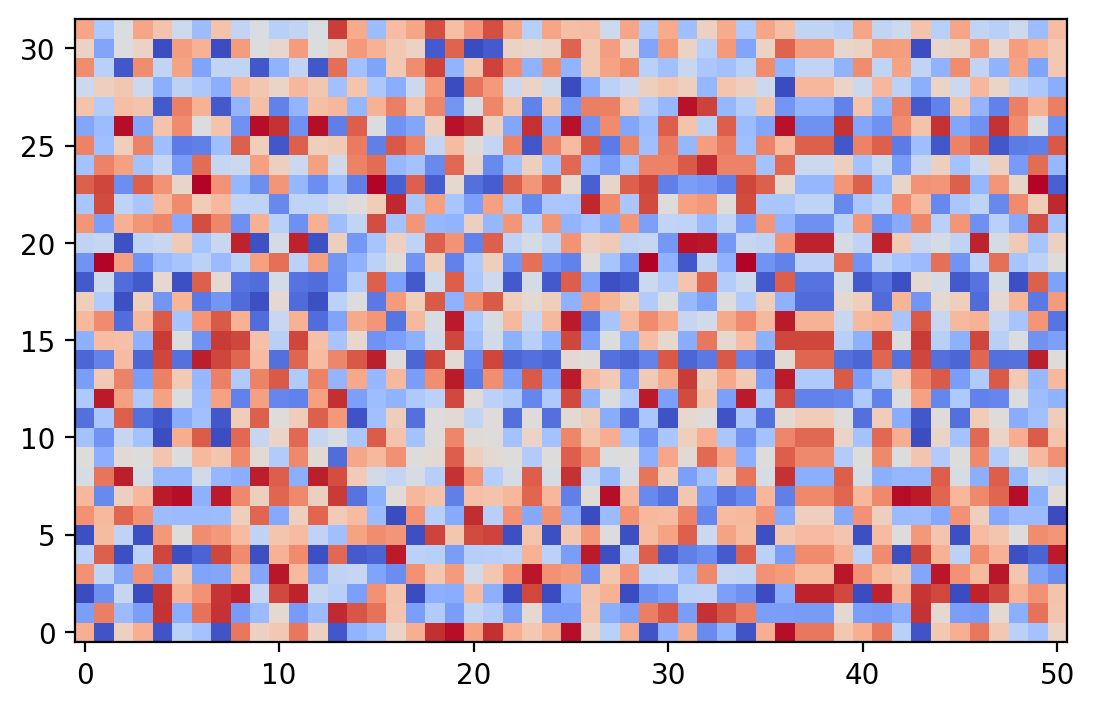

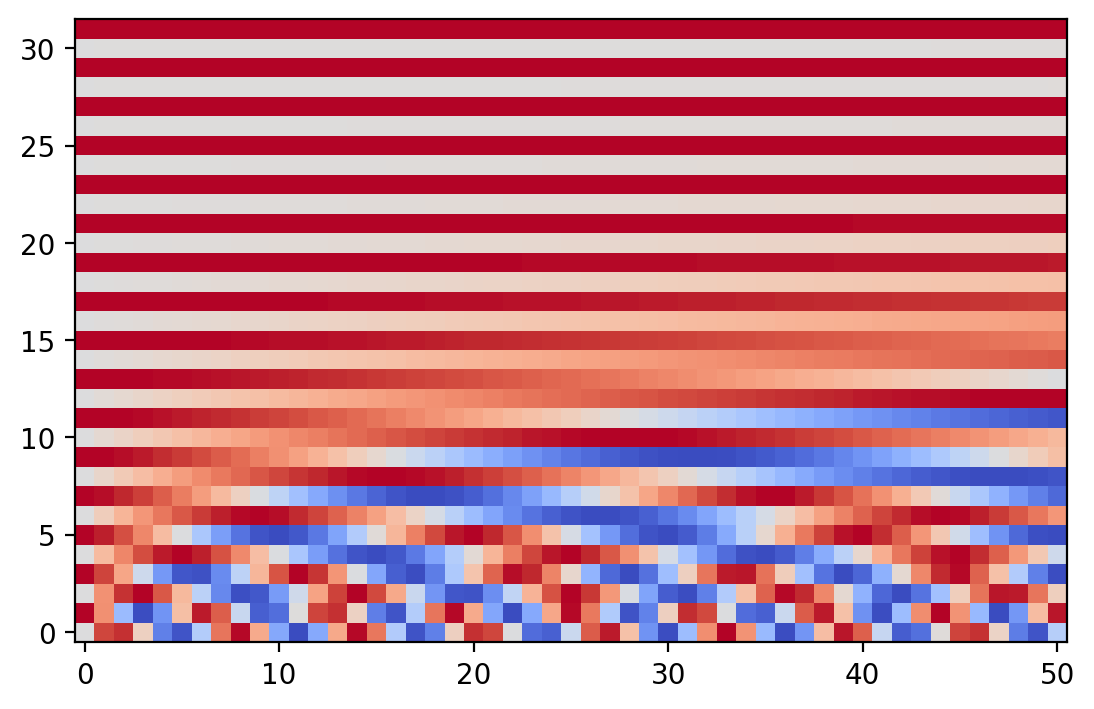

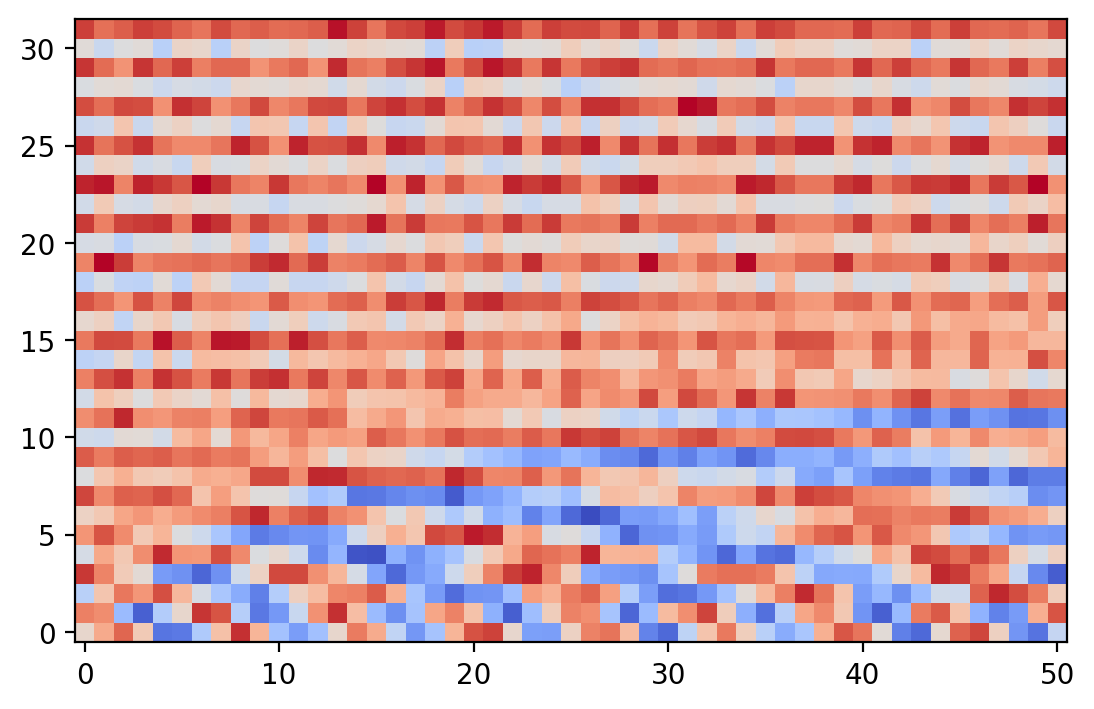

In [20]:
tpe = TokenAndPositionEmbedding(notes_vocab_size, 32)
token_embedding = tpe.token_emb(example_tokenised_notes)
position_embedding = tpe.pos_emb(token_embedding)
embedding = tpe(example_tokenised_notes)
plt.imshow(
    np.transpose(token_embedding),
    cmap="coolwarm",
    interpolation="nearest",
    origin="lower",
)
plt.show()
plt.imshow(
    np.transpose(position_embedding),
    cmap="coolwarm",
    interpolation="nearest",
    origin="lower",
)
plt.show()
plt.imshow(
    np.transpose(embedding),
    cmap="coolwarm",
    interpolation="nearest",
    origin="lower",
)
plt.show()

## 8. Build the Transformer model <a name="transformer_decoder"></a>

In [21]:
note_inputs = layers.Input(shape=(None,), dtype=tf.int32)
durations_inputs = layers.Input(shape=(None,), dtype=tf.int32)
note_embeddings = TokenAndPositionEmbedding(
    notes_vocab_size, EMBEDDING_DIM // 2
)(note_inputs)
duration_embeddings = TokenAndPositionEmbedding(
    durations_vocab_size, EMBEDDING_DIM // 2
)(durations_inputs)
embeddings = layers.Concatenate()([note_embeddings, duration_embeddings])
x, attention_scores = TransformerBlock(
    N_HEADS, KEY_DIM, EMBEDDING_DIM, FEED_FORWARD_DIM, name="attention"
)(embeddings)
note_outputs = layers.Dense(
    notes_vocab_size, activation="softmax", name="note_outputs"
)(x)
duration_outputs = layers.Dense(
    durations_vocab_size, activation="softmax", name="duration_outputs"
)(x)
model = models.Model(
    inputs=[note_inputs, durations_inputs],
    outputs=[note_outputs, duration_outputs],  # attention_scores
)
model.compile(
    "adam",
    loss=[
        losses.SparseCategoricalCrossentropy(),
        losses.SparseCategoricalCrossentropy(),
    ],
)
att_model = models.Model(
    inputs=[note_inputs, durations_inputs], outputs=attention_scores
)

In [22]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_and_position… │ (None, None, 128) │      7,552 │ input_layer[0][0] │
│ (TokenAndPositionE… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_and_position… │ (None, None, 128) │      3,072 │ input_layer_1[0]… │
│ (TokenAndPositionE… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, None, 256) │          0 │ token_and_positi… │
│ (Concatenate)       │                   │            │ token_and_positi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ [(None, None,     │  1,447,424 │ concatenate[0][0] │
│ (TransformerBlock)  │ 256), (None, 5,   │            │                   │
│                     │ None, None)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ note_outputs        │ (None, None, 59)  │     15,163 │ attention[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ duration_outputs    │ (None, None, 24)  │      6,168 │ attention[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,479,379 (5.64 MB)

 Trainable params: 1,479,379 (5.64 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
if LOAD_MODEL:
    # Si no hay un modelo final guardado, carga el último checkpoint y ajusta EPOCHS
    if not os.path.exists("./models/model.keras"):
        checkpoints = sorted(
            glob.glob("./checkpoint/checkpoint_epoch_*.weights.h5")
        )
        if not checkpoints:
            raise FileNotFoundError("No checkpoint files found under ./checkpoint")
        latest_checkpoint = checkpoints[-1]

        model.load_weights(latest_checkpoint)
        EPOCHS = EPOCHS - int(
            latest_checkpoint.split("_")[-1].split(".")[0]
        )
        print(f"Loading checkpoint: {latest_checkpoint}, adjusting EPOCHS to {EPOCHS}")
    else:
        model.load_weights("./models/model.keras")
        print("Loaded final model from ./models/model.keras")
else:
    print("Training model from scratch")

Loading checkpoint: ./checkpoint/checkpoint_epoch_1500.weights.h5, adjusting EPOCHS to 500


/Users/roicort/GitHub/PCIC/GenAI/.venv/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 46 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## 9. Train the Transformer <a name="train"></a>

In [24]:
# Create a MusicGenerator checkpoint
class MusicGenerator(callbacks.Callback):
    def __init__(self, index_to_note, index_to_duration, top_k=10, callback_every=500):
        self.index_to_note = index_to_note
        self.note_to_index = {
            note: index for index, note in enumerate(index_to_note)
        }
        self.index_to_duration = index_to_duration
        self.duration_to_index = {
            duration: index for index, duration in enumerate(index_to_duration)
        }
        self.callback_every = callback_every

    def sample_from(self, probs, temperature):
        probs = probs ** (1 / temperature)
        probs = probs / np.sum(probs)
        return np.random.choice(len(probs), p=probs), probs

    def get_note(self, notes, durations, temperature):
        sample_note_idx = 1
        while sample_note_idx == 1:
            sample_note_idx, note_probs = self.sample_from(
                notes[0][-1], temperature
            )
            sample_note = self.index_to_note[sample_note_idx]

        sample_duration_idx = 1
        while sample_duration_idx == 1:
            sample_duration_idx, duration_probs = self.sample_from(
                durations[0][-1], temperature
            )
            sample_duration = self.index_to_duration[sample_duration_idx]

        new_note = get_midi_note(sample_note, sample_duration)

        return (
            new_note,
            sample_note_idx,
            sample_note,
            note_probs,
            sample_duration_idx,
            sample_duration,
            duration_probs,
        )

    def generate(self, start_notes, start_durations, max_tokens, temperature):
        attention_model = models.Model(
            inputs=self.model.input,
            outputs=self.model.get_layer("attention").output,
        )

        start_note_tokens = [self.note_to_index.get(x, 1) for x in start_notes]
        start_duration_tokens = [
            self.duration_to_index.get(x, 1) for x in start_durations
        ]
        sample_note = None
        sample_duration = None
        info = []
        midi_stream = music21.stream.Stream()

        midi_stream.append(music21.clef.BassClef())

        for sample_note, sample_duration in zip(start_notes, start_durations):
            new_note = get_midi_note(sample_note, sample_duration)
            if new_note is not None:
                midi_stream.append(new_note)

        while len(start_note_tokens) < max_tokens:
            x1 = np.array([start_note_tokens])
            x2 = np.array([start_duration_tokens])
            notes, durations = self.model.predict([x1, x2], verbose=0)

            repeat = True

            while repeat:
                (
                    new_note,
                    sample_note_idx,
                    sample_note,
                    note_probs,
                    sample_duration_idx,
                    sample_duration,
                    duration_probs,
                ) = self.get_note(notes, durations, temperature)

                if (
                    isinstance(new_note, music21.chord.Chord)
                    or isinstance(new_note, music21.note.Note)
                    or isinstance(new_note, music21.note.Rest)
                ) and sample_duration == "0.0":
                    repeat = True
                else:
                    repeat = False

            if new_note is not None:
                midi_stream.append(new_note)

            _, att = attention_model.predict([x1, x2], verbose=0)

            info.append(
                {
                    "prompt": [start_notes.copy(), start_durations.copy()],
                    "midi": midi_stream,
                    "chosen_note": (sample_note, sample_duration),
                    "note_probs": note_probs,
                    "duration_probs": duration_probs,
                    "atts": att[0, :, -1, :],
                }
            )
            start_note_tokens.append(sample_note_idx)
            start_duration_tokens.append(sample_duration_idx)
            start_notes.append(sample_note)
            start_durations.append(sample_duration)

            if sample_note == "START":
                break

        return info

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.callback_every != 0:
            return
        info = self.generate(
            ["START"], ["0.0"], max_tokens=GENERATE_LEN, temperature=0.5
        )
        midi_stream = info[-1]["midi"].chordify()
        print(info[-1]["prompt"])
        midi_stream.show()
        midi_stream.write(
            "midi",
            fp=os.path.join(
                "./output",
                "partial-output-" + str(epoch).zfill(4) + ".mid",
            ),
        )

In [25]:
checkpoint_template = "./checkpoint/checkpoint_epoch_{epoch:04d}.weights.h5"
base_checkpoint = callbacks.ModelCheckpoint(
    filepath=checkpoint_template,
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

class SaveCheckpoint(callbacks.Callback):
    def __init__(self, wrapped_callback, every_n):
        super().__init__()
        self.wrapped_callback = wrapped_callback
        self.every_n = every_n

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.every_n == 0:
            self.wrapped_callback.set_model(self.model)
            self.wrapped_callback.on_epoch_end(epoch, logs)

interval_checkpoint = SaveCheckpoint(base_checkpoint, every_n=500)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

# Tokenize starting prompt
music_generator = MusicGenerator(
    notes_vocab,
    durations_vocab,
    callback_every=500,
)

Epoch 1/500


2025-12-04 12:52:37.357240: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


107/107 ━━━━━━━━━━━━━━━━━━━━ 28s 239ms/step - duration_outputs_loss: 0.7975 - loss: 3.4421 - note_outputs_loss: 2.6446
Epoch 2/500
107/107 ━━━━━━━━━━━━━━━━━━━━ 29s 271ms/step - duration_outputs_loss: 0.8027 - loss: 3.4415 - note_outputs_loss: 2.6388
Epoch 3/500
107/107 ━━━━━━━━━━━━━━━━━━━━ 27s 249ms/step - duration_outputs_loss: 0.8029 - loss: 3.4460 - note_outputs_loss: 2.6430
Epoch 4/500
107/107 ━━━━━━━━━━━━━━━━━━━━ 26s 246ms/step - duration_outputs_loss: 0.7924 - loss: 3.4391 - note_outputs_loss: 2.6467
Epoch 5/500
107/107 ━━━━━━━━━━━━━━━━━━━━ 29s 267ms/step - duration_outputs_loss: 0.7949 - loss: 3.4305 - note_outputs_loss: 2.6355
Epoch 6/500
107/107 ━━━━━━━━━━━━━━━━━━━━ 28s 264ms/step - duration_outputs_loss: 0.7950 - loss: 3.4390 - note_outputs_loss: 2.6440
Epoch 7/500
107/107 ━━━━━━━━━━━━━━━━━━━━ 27s 254ms/step - duration_outputs_loss: 0.8000 - loss: 3.4447 - note_outputs_loss: 2.6446
Epoch 8/500
107/107 ━━━━━━━━━━━━━━━━━━━━ 27s 249ms/step - duration_outputs_loss: 0.8005 - loss:

/Users/roicort/GitHub/PCIC/GenAI/.venv/lib/python3.11/site-packages/keras/src/ops/nn.py:938: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1, 5, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


[['START', 'E-:major', '4/4TS', 'rest', 'E-3', 'E-3', 'F3', 'G3', 'G3', 'G#3', 'B-3', 'G3', 'G3', 'F3', 'E-3', 'E-3', 'D3', 'E-3', 'G3', 'G#3', 'G3', 'G#3', 'G3', 'F3', 'G3', 'F3', 'E-3', 'F3', 'E-3', 'G3', 'G#3', 'B-3', 'B-3', 'G#3', 'G3', 'F3', 'G3', 'F3', 'B-3', 'G3', 'G3', 'B-3', 'B-3', 'G3', 'G3', 'G3', 'G3', 'E3', 'G3'], ['0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.25']]


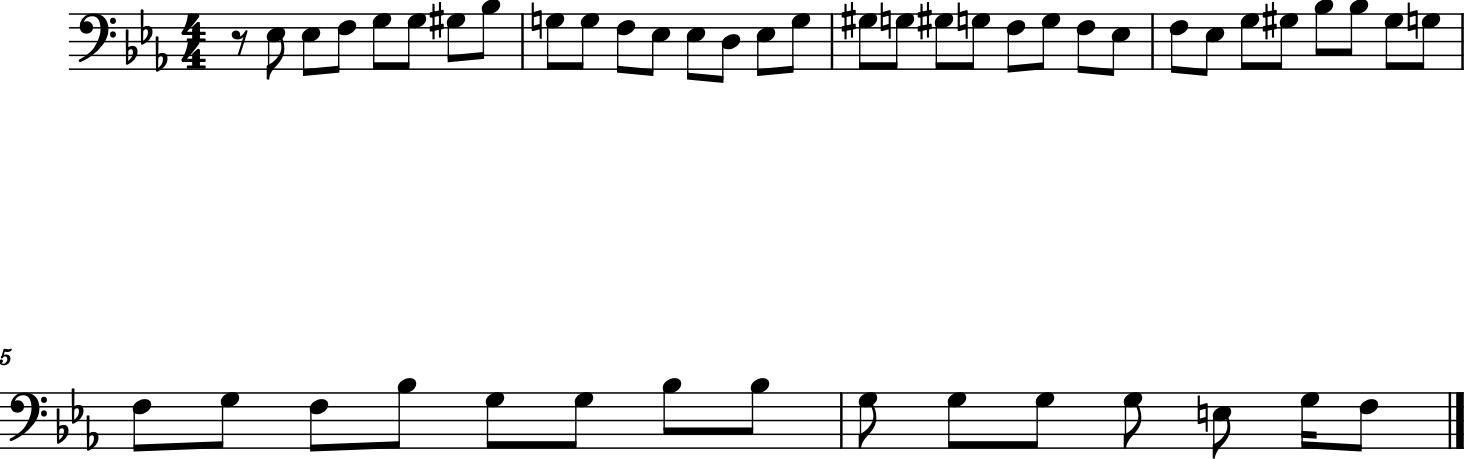

107/107 ━━━━━━━━━━━━━━━━━━━━ 43s 407ms/step - duration_outputs_loss: 0.8082 - loss: 3.4490 - note_outputs_loss: 2.6408


In [26]:
model.fit(
    ds,
    epochs=EPOCHS,
    callbacks=[
        interval_checkpoint,
        tensorboard_callback,
        music_generator,
    ],
)

In [27]:
# Save the final model
model.save("./models/model.keras")

# 3. Generate music using the Transformer

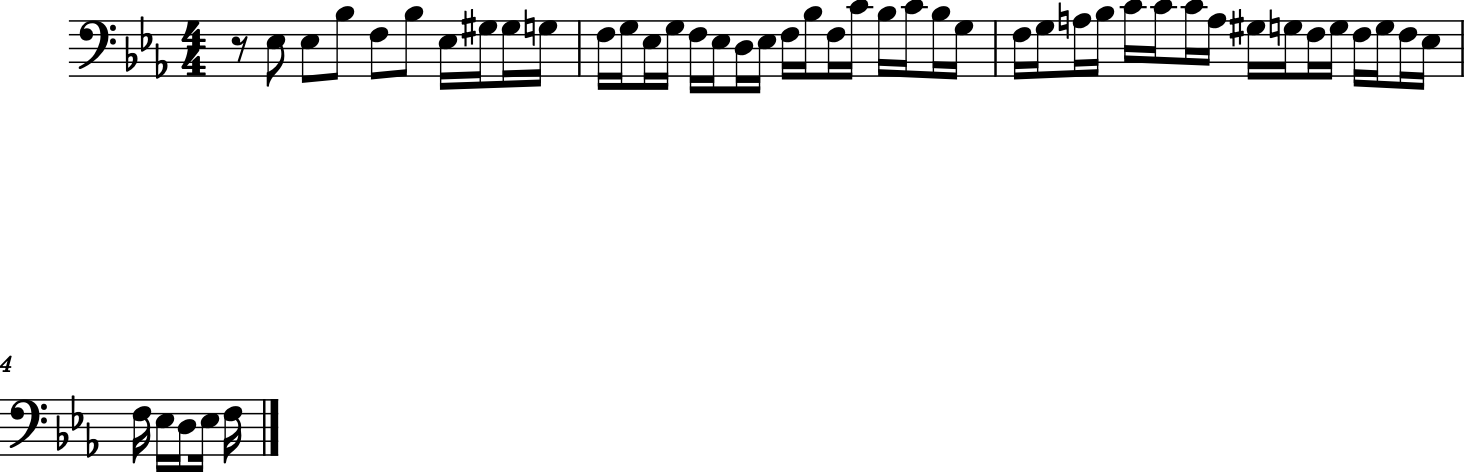

In [28]:
info = music_generator.generate(
    ["START"], ["0.0"], max_tokens=50, temperature=0.5
)
midi_stream = info[-1]["midi"].chordify()
midi_stream.show()

## Write music to MIDI file

In [29]:
timestr = time.strftime("%Y%m%d-%H%M%S")
midi_stream.write(
    "midi",
    fp=os.path.join(
        "./output",
        "output-" + timestr + ".mid",
    ),
)

'./output/output-20251204-190445.mid'

## Note probabilities

In [30]:
max_pitch = 70
seq_len = len(info)
grid = np.zeros((max_pitch, seq_len), dtype=np.float32)

for j in range(seq_len):
    for i, prob in enumerate(info[j]["note_probs"]):
        try:
            pitch = music21.note.Note(notes_vocab[i]).pitch.midi
            grid[pitch, j] = prob
        except:
            pass  # Don't show key / time signatures

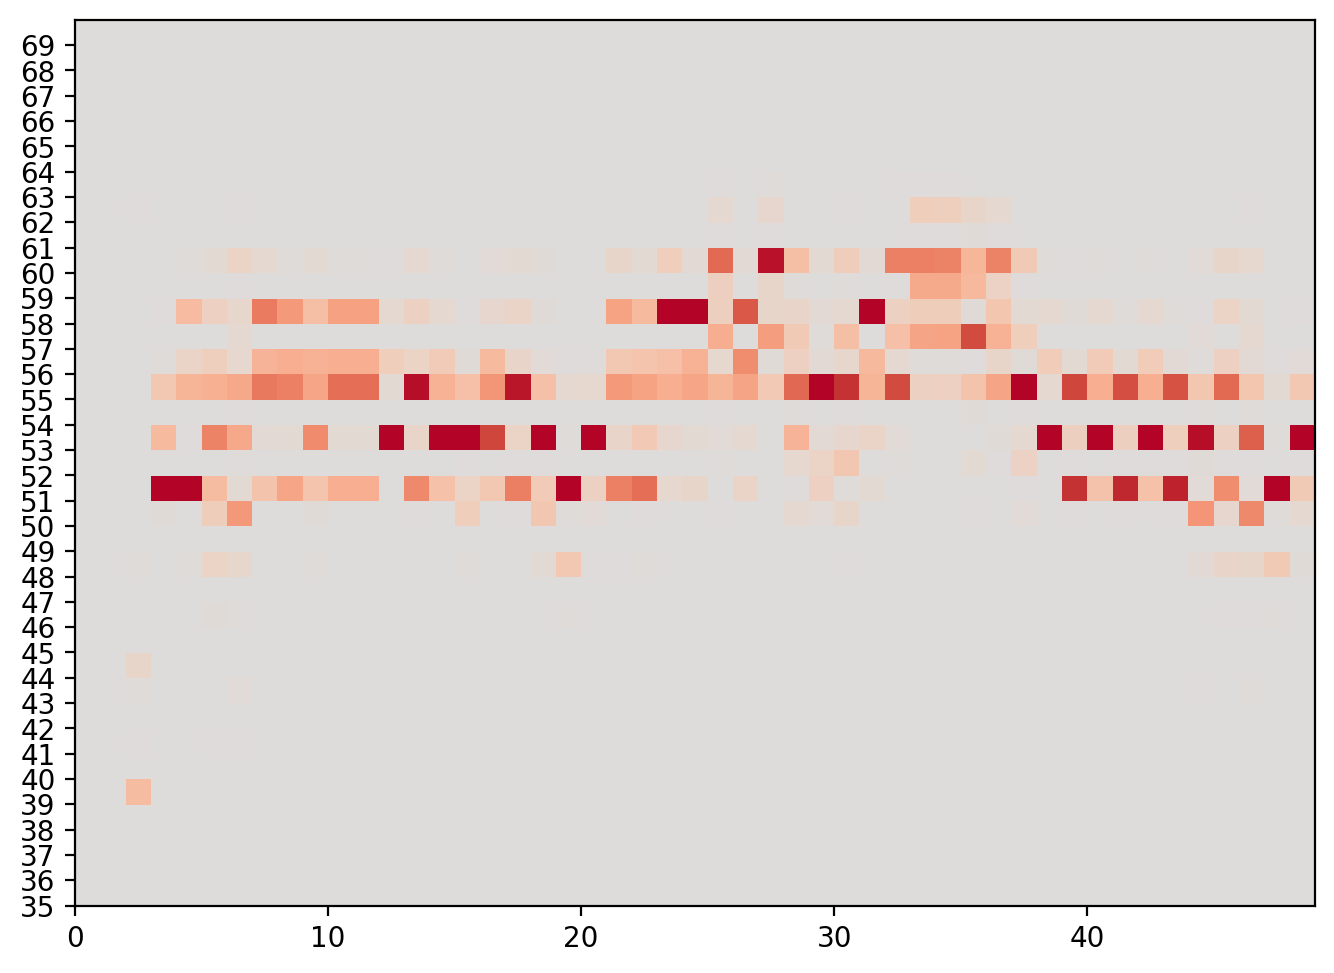

In [31]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_yticks([int(j) for j in range(35, 70)])
plt.imshow(
    grid[35:70, :],
    origin="lower",
    cmap="coolwarm",
    vmin=-0.5,
    vmax=0.5,
    extent=[0, seq_len, 35, 70],
)
plt.show()

## Attention Plot

In [32]:
plot_size = 20

att_matrix = np.zeros((plot_size, plot_size))
prediction_output = []
last_prompt = []

In [33]:
for j in range(plot_size):
    atts = info[j]["atts"].max(axis=0)
    att_matrix[: (j + 1), j] = atts
    prediction_output.append(info[j]["chosen_note"][0])
    last_prompt.append(info[j]["prompt"][0][-1])

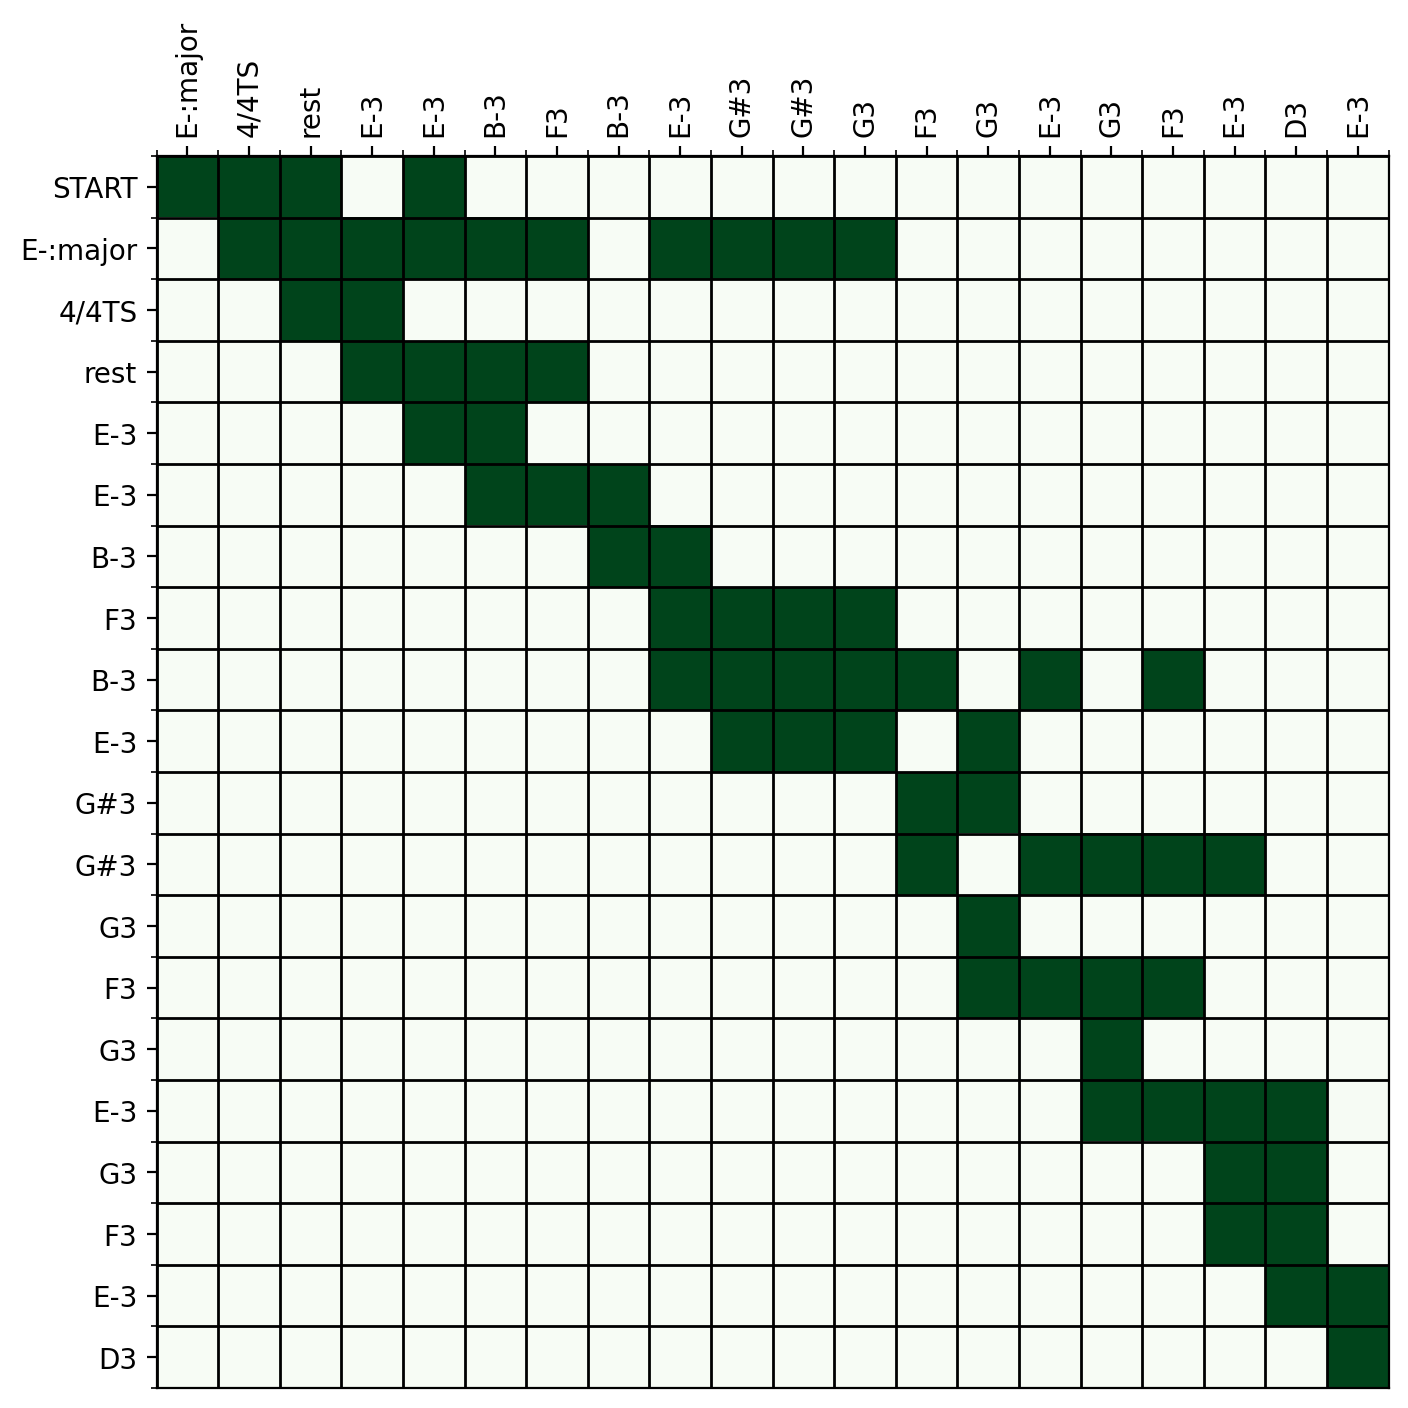

In [34]:
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(att_matrix, cmap="Greens", interpolation="nearest")

ax.set_xticks(np.arange(-0.5, plot_size, 1), minor=True)
ax.set_yticks(np.arange(-0.5, plot_size, 1), minor=True)
ax.grid(which="minor", color="black", linestyle="-", linewidth=1)
ax.set_xticks(np.arange(plot_size))
ax.set_yticks(np.arange(plot_size))
ax.set_xticklabels(prediction_output[:plot_size])
ax.set_yticklabels(last_prompt[:plot_size])
ax.xaxis.tick_top()

plt.setp(
    ax.get_xticklabels(),
    rotation=90,
    ha="left",
    va="center",
    rotation_mode="anchor",
)
plt.show()